# Modelado del conjunto de datos
A lo largo de este notebook se cubre la tercera fase de la metodología CRIPS-DM, en este caso la preparación dec los datos

1. **Comprensión del Negocio (Business Understanding)**
   - Consistente en el entendimiento del objetivo del proyecto.

2. **Comprensión de los Datos (Data Understanding)**
   - Relacionada con la carga y primera evaluación del conjunto de datos. Se divide a su vez en :


3. **Preparación de los Datos (Data Preparation)** 
   - Consistente en la limpieza, preparación y extracción de características de los datos.

4. <span style="color:#66FF99;">**Modelado (Modeling)**  </span> 
   - Relacionada con la elección del modelo de machine learning y el ajuste hiperparamétrico.

5. **Evaluación (Evaluation)**  
   - Evaluación de los resultados obtenidos por el modelo.

6. **Implementación (Deployment)**  
   - Integración del modelo de forma que sea accesible para su uso.


### Arquitectura propuesta


En este caso, la arquitectura propuesta, representada inferiormente, puede dividirse en dos bloques diferenciados:

1) Detector de objetos mediante Yolov8, obtieninedo como salida las bounding-boxes asociadas.
2) Segmentador de instancias mediante Segment Anything Model a partir de las bounding boxes anteriores.
3) Agrupador de máscaras de instancias en formato de imagen con las máscaras de la segmentación semántica correspondiente.


<img src="./../assets/figs/proposed_retinnet.png" alt="Arquitectura propuesta empleando RetinaNet" style="width: 70%; height: auto;">

## 1. Obtención de las *bounding boxes*

Como primer bloque de la pipeline se desarrolla el código equivalente para la realización de la detección de los objetos.

Para ello se emplea el modelo Retinanet, empleado principalmente por el uso de la funcoón de pérdida focal loss que mejora los resultados tras el entrenamiento en clases que ocupan espacios pequeños en fondos grandes, como sucede en este dataset. 

La aruitectura de este modeo se observa inferiormente:


<img src=".\..\assets\figs\The-architecture-of-the-proposed-model-R-RetinaNet.png" alt="Arquitectura propuesta empleando RetinaNet" style="width: 60%; height: auto;">

In [ ]:
from ultralytics import YOLO
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import importlib
import utils

importlib.reload(utils)


import cv2
import torch
import random
import cv2
import numpy as np
import os
import utils 
from utils import  load_yaml_file, plot_bounding_boxes, plot_bounding_boxes_non_tensor, plot_differences_batch
from pycocotools.coco import COCO

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor



Se carga todas las constantes relativas al proyecto y la API de COCO

In [106]:
yaml = load_yaml_file()
objetives = yaml["objetive_classes"]

In [107]:
# Tamaño de la muestra a inferir

N = yaml["size_sample"]

In [28]:
N_CLASSES = len(objetives) + 1

DIR_TRAIN_ANNOTATIONS = yaml["dirs"]["anotaciones"]["train"]
DIR_TRAIN_IMGS = yaml["dirs"]["imagenes"]["train"]
DIR_TRAIN_IMGS = os.path.abspath(os.path.join(os.getcwd(), "..", DIR_TRAIN_IMGS))

coco=COCO(os.path.join(os.getcwd(),"..", DIR_TRAIN_ANNOTATIONS))

loading annotations into memory...


Done (t=37.69s)
creating index...
index created!


In [29]:
categories = coco.loadCats(coco.getCatIds())
category_info_id = {cat['id']: cat['name'] for cat in categories}
category_info_name = { cat['name']:cat['id'] for cat in categories}

id_objetives = [category_info_name[name] for name in objetives]
category_info_objetive = {i:category_info_id[i] for i in id_objetives}
category_info_objetive[0] = "background"
categories_names_by_index = { i: category_info_objetive[id_cat] for i , id_cat in enumerate(sorted(category_info_objetive.keys()))}

In [30]:
img_ids = set(coco.getImgIds(catIds=id_objetives[0]))

for cat in id_objetives[1:]:
    img_ids |= set(coco.getImgIds(catIds=cat))

img_ids = list(img_ids)


print(f"Las imagenes con alguna instancia de las clases target son {len(img_ids)}")

Las imagenes con alguna instancia de las clases target son 79542


En primera instancia se realiza la carga del modelo desde la libreria `ultralytics` en este caso en su version v8

In [33]:

model = YOLO("yolov8s.pt") 


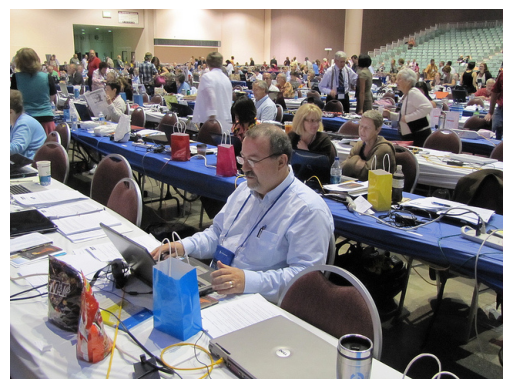

In [ ]:

image_path = r"C:\Users\ruben\Desktop\code_tfm\dataset\coco\train2017\000000001756.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



In [77]:
results = model(image)



0: 480x640 12 persons, 2 bottles, 2 cups, 12 chairs, 14 laptops, 1 keyboard, 1 book, 822.8ms
Speed: 8.7ms preprocess, 822.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


In [82]:
print("El número de instancias encontradas es de ",len(results[0]), "\n")
print("Los resultados son tales que \n ",results[0], "\n")


El número de instancias encontradas es de  44 

Los resultados son tales que 
  ultralytics.yolo.engine.results.Results object with attributes:

boxes: ultralytics.yolo.engine.results.Boxes object
keypoints: None
keys: ['boxes']
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'c

In [79]:
results[0].boxes.conf

tensor([0.8838, 0.8713, 0.8309, 0.8230, 0.8214, 0.8107, 0.7993, 0.7559, 0.7516, 0.7450, 0.7383, 0.7347, 0.7246, 0.7207, 0.6813, 0.6795, 0.6693, 0.6495, 0.6396, 0.5947, 0.5796, 0.5699, 0.5609, 0.5581, 0.5455, 0.5134, 0.4446, 0.4159, 0.3985, 0.3943, 0.3935, 0.3698, 0.3394, 0.3324, 0.3199, 0.3158, 0.3072, 0.3000, 0.2841,
        0.2799, 0.2725, 0.2716, 0.2629, 0.2529])

In [135]:
results_images = []
results_inference = []


for i, id_image in tqdm(enumerate(img_ids[:10]), total=10):
    inference = {}
    yolo_boxes = []
    yolo_label  = []
    yolo_prob = []

    img_info = coco.loadImgs(id_image)[0]
    img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"
    image = Image.open(img_path).convert("RGB")
    results_images.append(image)

    results = model(image)

    for box_info in results[0]:
        x1,y1,x2,y2, conf, label = box_info.boxes.data[0].tolist()

        # Dado que yolo detecta más clases que nuestro conjunto de objetivos presente, filtramos las bounding boxes encontradas
        if (label+1) in id_objetives:
            #x1,y1,x2,y2 = map(int, box.xyxy[0])
            yolo_boxes.append( (x1,y1,x2,y2))
            yolo_prob.append(conf)
            yolo_label.append(label + 1)


    inference["boxes"] = yolo_boxes
    inference["scores"] = yolo_prob
    inference["labels"] = yolo_label




    # print("Instancias detectadas ", len(yolo_boxes))
    # print("Probabilidades asociadas: ", yolo_prob)

    results_inference.append(inference)



  0%|          | 0/10 [00:00<?, ?it/s]
0: 448x640 12 persons, 1 backpack, 4 umbrellas, 1 cup, 2 carrots, 505.9ms
Speed: 5.1ms preprocess, 505.9ms inference, 4.8ms postprocess per image at shape (1, 3, 448, 640)
 10%|█         | 1/10 [00:00<00:04,  1.86it/s]
0: 640x480 1 person, 1 backpack, 1 skis, 381.9ms
Speed: 3.8ms preprocess, 381.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
 20%|██        | 2/10 [00:00<00:03,  2.16it/s]
0: 448x640 2 persons, 2 dogs, 2 frisbees, 315.8ms
Speed: 5.0ms preprocess, 315.8ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)
 30%|███       | 3/10 [00:01<00:02,  2.45it/s]
0: 512x640 15 persons, 1 bench, 1 skateboard, 346.2ms
Speed: 5.1ms preprocess, 346.2ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)
 40%|████      | 4/10 [00:01<00:02,  2.55it/s]
0: 448x640 3 persons, 1 dog, 1 bear, 1 umbrella, 341.4ms
Speed: 3.2ms preprocess, 341.4ms inference, 3.5ms postprocess per image at shape (1, 3, 448, 640)

C:\Users\ruben\AppData\Local\Temp\ipykernel_18108\3505818853.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map={cls: plt.cm.get_cmap('tab10')(i) for i, cls in enumerate(id_objetives)}


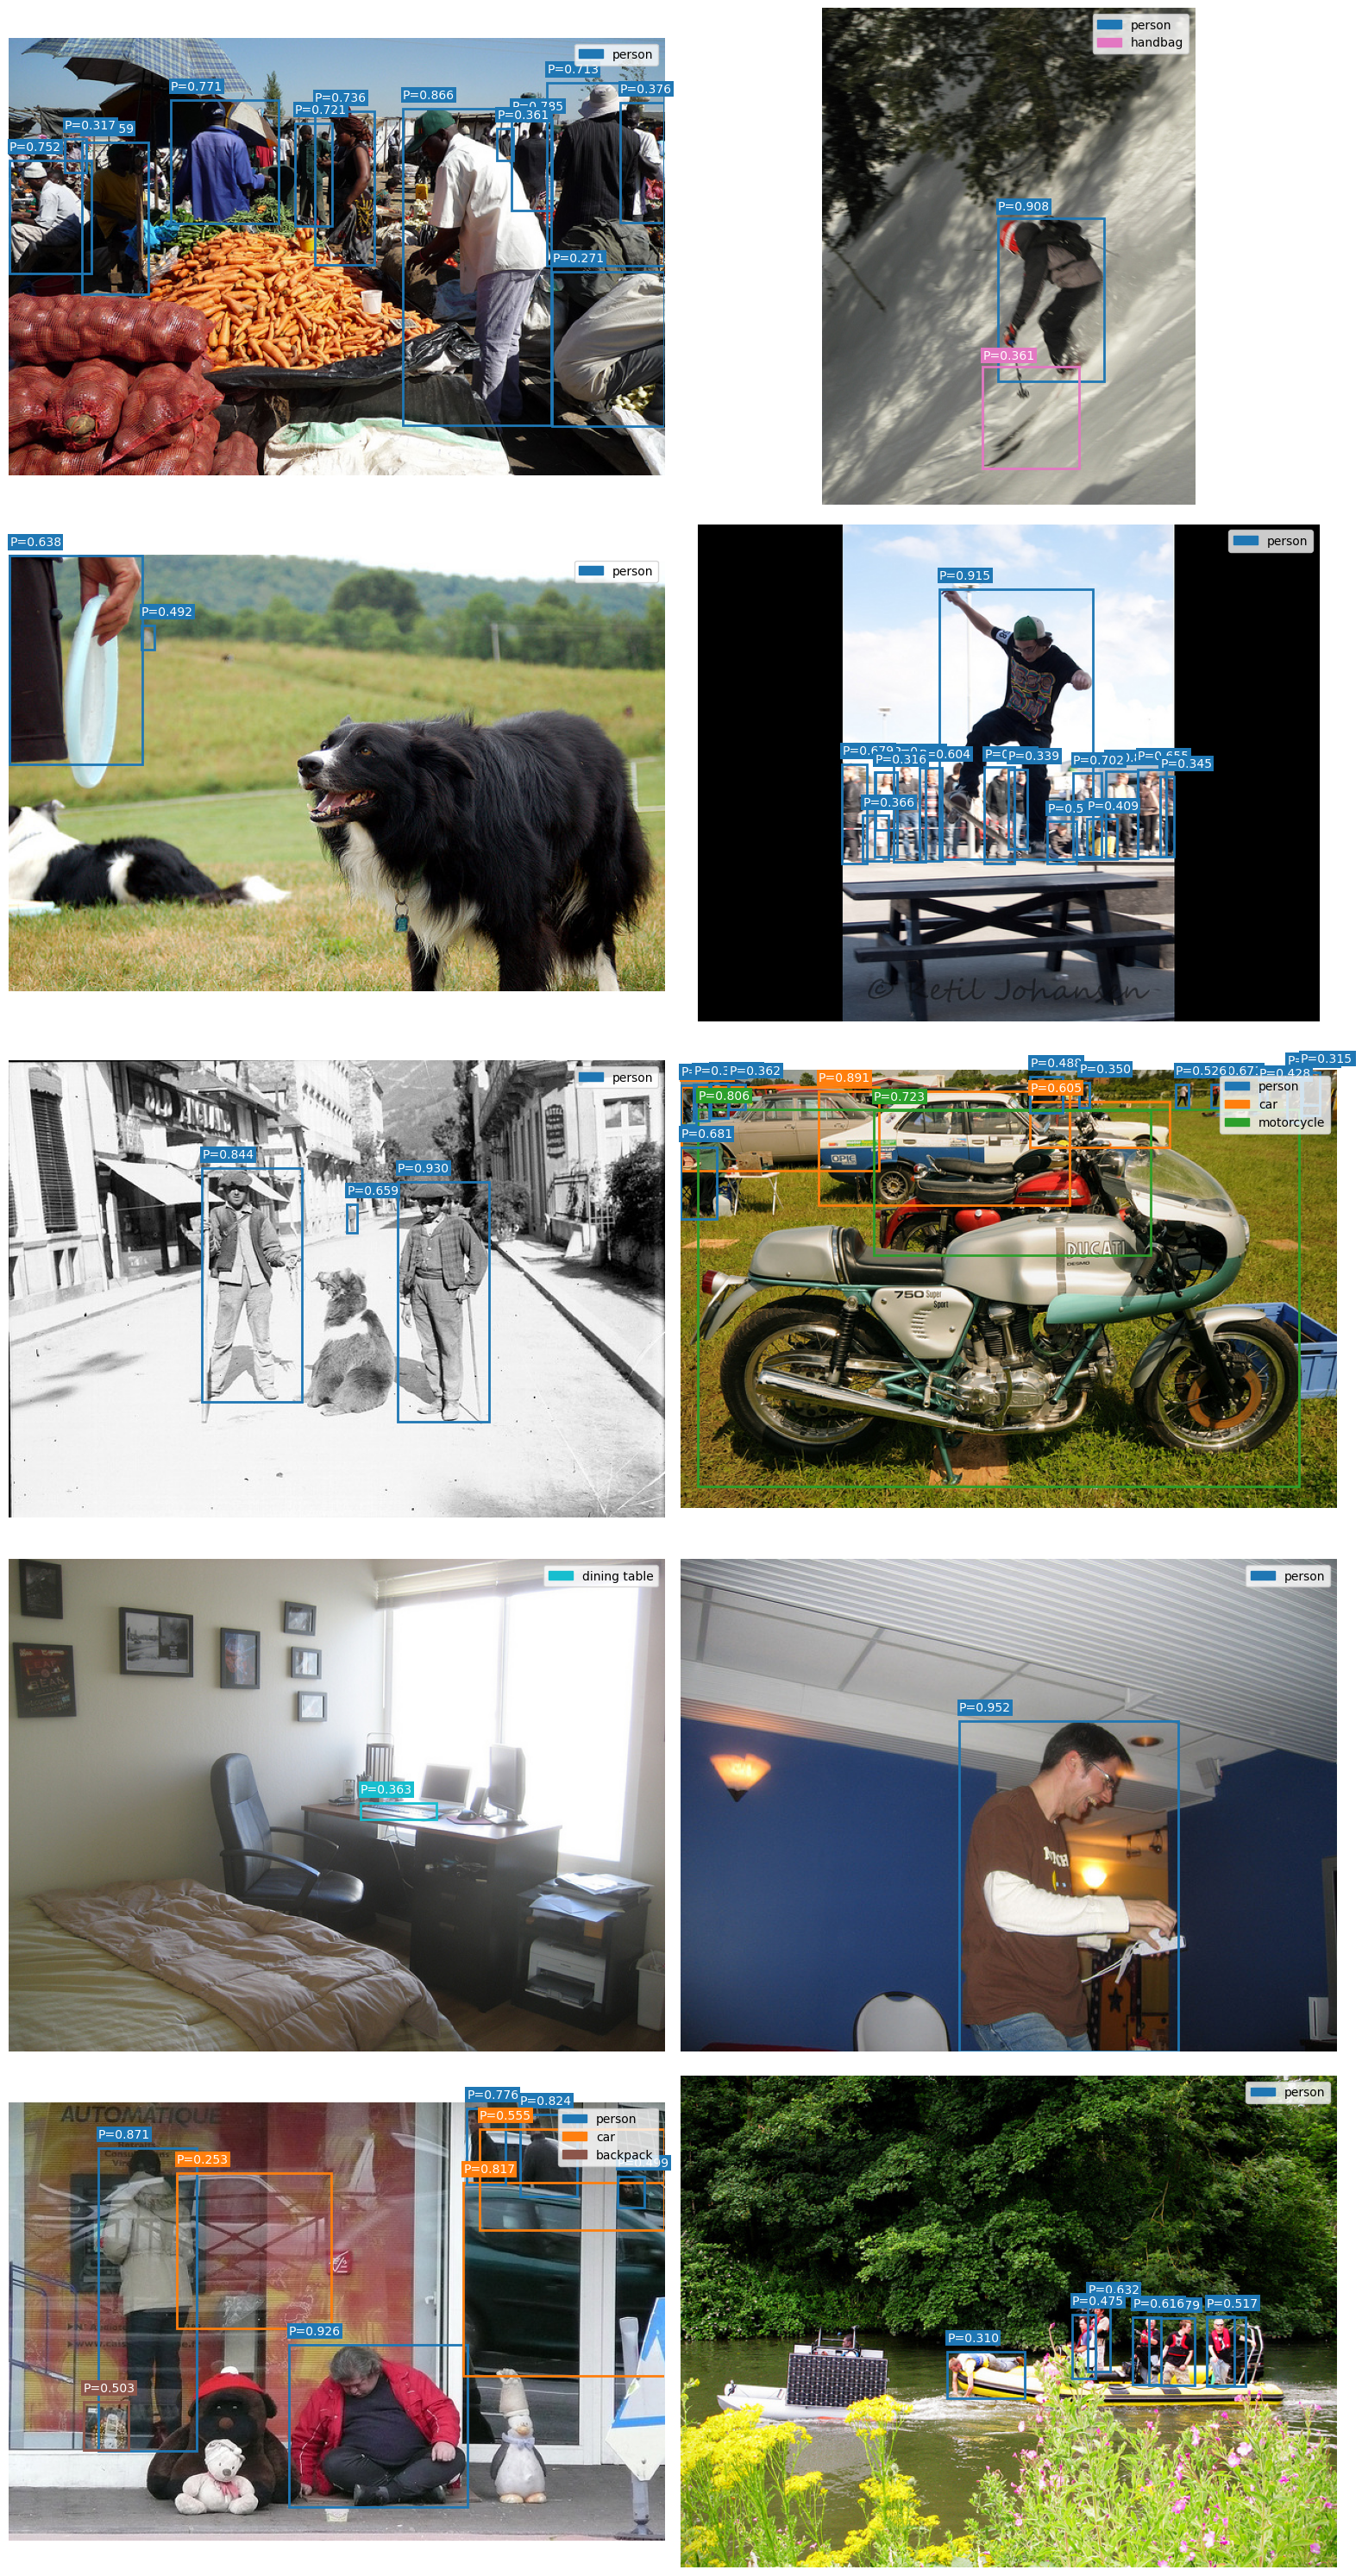

In [140]:
plot_bounding_boxes_non_tensor(results_images,results_inference,category_info_objetive, 0.0)

A continuación, realizamos la inferencia en las N primeras instancias, de acuerdo con el valor de N definido en el fichero `config.yml` que contendrá el valor de muestras sobre el que se calcularán las métricas

In [ ]:
results_images = []
results_inference = []

# Cambiamos a modo no verboso para evitar que llene la consola con cada inferencia
model.overrides['verbose'] = False


for i, id_image in tqdm(enumerate(img_ids[:N]), total=N):
    inference = {}
    yolo_boxes = []
    yolo_label  = []
    yolo_prob = []

    img_info = coco.loadImgs(id_image)[0]
    img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"
    image = Image.open(img_path).convert("RGB")
    results_images.append(image)

    results = model(image)

    for box_info in results[0]:
        x1,y1,x2,y2, conf, label = box_info.boxes.data[0].tolist()

        # Dado que yolo detecta más clases que nuestro conjunto de objetivos presente, filtramos las bounding boxes encontradas
        if (label+1) in id_objetives:
            #x1,y1,x2,y2 = map(int, box.xyxy[0])
            yolo_boxes.append( (x1,y1,x2,y2))
            yolo_prob.append(conf)
            yolo_label.append(label + 1)


    inference["boxes"] = yolo_boxes
    inference["scores"] = yolo_prob
    inference["labels"] = yolo_label


    results_inference.append(inference)



 62%|██████▏   | 6199/10000 [38:41<22:18,  2.84it/s]  

### Obtención de las máscaras asociadas


Se hace uso del modelo SAM para obtener las máscaras de segmentación a partir de las bounding boxes obtenidas de cada una de las imágenes

In [ ]:

sam_checkpoint = r"C:\Users\ruben\Desktop\code_tfm\models\SAM\sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device= "cpu" )

sam_model = SamPredictor(sam)

In [ ]:
CONS_TRHESHOLD = 0.5

In [ ]:
def get_mask(image_id):
    img_info = coco.loadImgs(image_id)[0]
    height, width = img_info['height'], img_info['width']

    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((height, width), dtype=np.uint8)

    for ann in anns:
        category_id = ann['category_id']

        if(category_id in category_info_objetive.keys()):
        
            binary_mask = coco.annToMask(ann)
            mask[binary_mask == 1] = category_id

    return mask




def get_one_hot_scores(current_scores, mask,categories_names_by_index ):
    mask = mask[0]
    one_hot_scores = np.zeros((len(categories_names_by_index), mask.shape[0], mask.shape[1]))

    for clase in sorted(categories_names_by_index.keys()):
        # print("mask shapes", mask.shape)
        # print("class", clase)
        # print("shapes ", one_hot_scores.shape)
        # print("scores shape ", current_scores.shape)
        one_hot_scores[clase, :, :] = np.where(mask == clase,current_scores[0, :, :]  , 0)

    one_hot_scores[0, :, :] = 1 - one_hot_scores[1:, :, :].sum(axis=0)

    #print("output has shape", one_hot_scores.shape)

    return one_hot_scores

Obtenemos los resultados finales de las N primeras máscaras

In [ ]:
dict_class_index = {key:i for i , key in enumerate(sorted(category_info_objetive.keys()))}

In [ ]:

final_masks = []
masks_scores = []
masks_logits = []
one_hot_scores = []
mask_index = []
ground_truth = []


for i, (img_id, results_detection) in enumerate(tqdm(zip(img_ids[:5], results_inference[:5]), total=len(img_ids[:5]))):

    masks_image = []
    mask_target = []
    scores_image = []
    logits_image = []
    labels_image = []
    mask_probs_image = []

    gt_mask = get_mask(img_id)
    ground_truth.append(gt_mask)

    img_info = coco.loadImgs(img_id)[0]
    img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sam_model.set_image(image)

    final_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    current_scores = np.zeros(image.shape[:2], dtype=np.uint8)

    for box, score, label in zip(results_detection['boxes'], results_detection['scores'], results_detection['labels']):
        if(score > CONS_TRHESHOLD and label in category_info_objetive.keys()):
            masks, scores, logits = sam_model.predict(
                point_coords=None,
                point_labels=None,
                box= np.array(box.tolist())[None, :] ,
                multimask_output=False
            )
            
            
            # print("image has shape ",image.shape )
            # print("mask have shape ",masks.shape )
            # print("logits has shape ",logits.shape )
            
            # print("\n")
            
            masks_image.append(masks)
            scores_image.append(scores)
            logits_image.append(logits[0])
            labels_image.append(label)

    # print("scores are ", scores_image, "for classes ", labels_image)


    for mask, mask_score, label in zip(masks_image, scores_image, labels_image):
        if np.any(mask):
            # print("mask has avlue and label is ", label)
            mask_values = np.where(mask, mask_score, 0)
            final_mask = np.where(mask_values > current_scores , label, final_mask)

            # print("current final value is ", np.unique(final_mask))
            current_scores = np.maximum(mask_values, current_scores)

    # print("\n\n")




    final_masks.append(final_mask[0])
    masks_scores.append(current_scores)

    lookup = np.vectorize(lambda k: dict_class_index[k])
    mask_by_index = lookup(final_mask)
    mask_index.append(mask_by_index) 
    one_hot_scores.append(get_one_hot_scores(current_scores,mask_by_index,categories_names_by_index))






In [ ]:
plot_differences_batch(results_images[:5], ground_truth, final_masks, category_info_objetive)


#### Métricas de rendimiento


Por último, se capturan las métricas de rendimiento asociadas y se guardan en el fichero `csv`